In [1]:
# Import libraries
import pandas as pd
import datetime as dt
import os
import h5py
import numpy as np
import sys
sys.path.insert(0, '/Users/acheung/TC_RI_P1/scripts/Useful Functions/')
from distance import distance_calculator
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from metpy.plots import ctables
cmap = ctables.registry.get_colortable('precipitation')
import xarray as xr
import multiprocessing

In [2]:
# Enter time and Location

start_str = "2020-11-09 00:00:00"
end_str = "2020-11-12 00:00:00"

times_pd = pd.date_range(start=start_str,end=end_str, freq='30min')
times_pd = times_pd[0:-1]
desired_lon = -81.38
desired_lat = 28.54

In [3]:
filepaths = []
for i in times_pd: # Download all the desired IMERG Images
    # If IMERG file does not exist, download it
    
    year = i.year
    day_of_year = i.strftime('%j')
    day_stripped = i.strftime('%Y%m%d')
    time_stripped = i.strftime('%H%M%S')
    min_of_day = str(i.hour*60 + i.minute).zfill(4)
    end_time_stripped = (i+dt.timedelta(minutes=29,seconds=59)).strftime('%H%M%S')
        
    IMERG_file_path = '/Users/acheung/data/IMERG/'+str(year)+'/'+day_of_year+'/'+\
            '3B-HHR.MS.MRG.3IMERG.'+day_stripped+'-S'+time_stripped+'-E'+end_time_stripped+\
            '.'+min_of_day+'.V07B.HDF5'  

# If day directory does not exist, make day directory
    if os.path.exists('/Users/acheung/data/IMERG/'+str(year)) == False:
        os.mkdir('/Users/acheung/data/IMERG/'+str(year))

    if os.path.exists('/Users/acheung/data/IMERG/'+str(year)+'/'+day_of_year) == False:
        os.mkdir('/Users/acheung/data/IMERG/'+str(year)+'/'+day_of_year)

    if os.path.exists(IMERG_file_path) == False:
        url_desired = "https://gpm1.gesdisc.eosdis.nasa.gov/data/GPM_L3/GPM_3IMERGHH.07/"\
            +str(year)+'/'+day_of_year+'/'+'3B-HHR.MS.MRG.3IMERG.'+day_stripped+'-S'+time_stripped+\
            '-E'+end_time_stripped+'.'+min_of_day+'.V07B.HDF5'
        os.chdir('/Users/acheung/data/IMERG/'+str(year)+'/'+day_of_year)

        os.system('wget --load-cookies ~/.urs_cookies --save-cookies ~/.urs_cookies --keep-session-cookies '
                  + url_desired)
    filepaths.append(IMERG_file_path)


In [22]:
def process_imerg(case_loop,imerg_total_precip,filepaths,desired_lon,desired_lat,sliced_lon_arr,sliced_lat_arr):
    import numpy as np
    import xarray as xr
    import sys
    sys.path.insert(0, '/Users/acheung/TC_RI_P1/scripts/Useful Functions/')
    from distance import distance_calculator
    fn = filepaths[case_loop]
    print(fn)
    try:
        f = h5py.File(fn, 'r')
    except: # If the file is corrupt, remove and re-download
        os.system('rm ' + fn)
        os.chdir(fn[0:35])
        new_url = 'https://gpm1.gesdisc.eosdis.nasa.gov/data/GPM_L3/GPM_3IMERGHH.07/' + fn[26:]
        os.system('wget --load-cookies ~/.urs_cookies --save-cookies ~/.urs_cookies --keep-session-cookies '
                  + new_url)
        f = h5py.File(fn, 'r')

    # Work on precip file
    groups = [ x for x in f.keys() ]
    # print(groups)
    gridMembers = [ x for x in f['Grid'] ]
    # print(gridMembers)

    # Get the precipitation, latitude, and longitude variables
    precip = f['Grid/precipitation'][0][:][:]
    precip = np.transpose(precip)
    precip[precip<-999]=np.nan

    theLats = f['Grid/lat'][:]
    theLons = f['Grid/lon'][:]
    x, y = np.float32(np.meshgrid(theLons, theLats))

    # Find index closest to interpolated best-track center or 2-km radar center
    distance_arr = distance_calculator(x, y,(desired_lon,desired_lat))

    abs_dist_arr = (abs(distance_arr))

    min_dist_ind = np.where(abs_dist_arr == np.nanmin(abs_dist_arr))

    # Slice arrays to within 30 indices of desired center

    sliced_lon_grid = x[min_dist_ind[0][0]-30:min_dist_ind[0][0]+30,min_dist_ind[1][0]-30:min_dist_ind[1][0]+30]

    sliced_lat_grid = y[min_dist_ind[0][0]-30:min_dist_ind[0][0]+30,min_dist_ind[1][0]-30:min_dist_ind[1][0]+30]

    sliced_precip = precip[min_dist_ind[0][0]-30:min_dist_ind[0][0]+30,min_dist_ind[1][0]-30:min_dist_ind[1][0]+30]

    imerg_total_precip[case_loop] = sliced_precip

    if case_loop == 0: # Only grab lat/lon array once for plotting later
        sliced_lat_arr[case_loop] = sliced_lat_grid
        sliced_lon_arr[case_loop] = sliced_lon_grid


if __name__ == "__main__": # Run multiprocesses
    manager = multiprocessing.Manager()
    imerg_total_precip = manager.dict()
    sliced_lat_arr = manager.dict()
    sliced_lon_arr = manager.dict()
    jobs = []
    for i in range(len(filepaths)):
        p = multiprocessing.Process(target=process_imerg, args=(i, imerg_total_precip,filepaths,desired_lon,desired_lat,
                                                               sliced_lon_arr,sliced_lat_arr))
        jobs.append(p)
        p.start()

    for proc in jobs:
        proc.join()
        
# Sum up precipitation (MRMS data is hourly QPE)
total_precip = np.sum(np.asarray(imerg_total_precip.values()),axis=0) * 0.5

sliced_lat_grid = sliced_lat_arr.values()[0]
sliced_lon_grid = sliced_lon_arr.values()[0]


/Users/acheung/data/IMERG/2020/314/3B-HHR.MS.MRG.3IMERG.20201109-S000000-E002959.0000.V07B.HDF5
/Users/acheung/data/IMERG/2020/314/3B-HHR.MS.MRG.3IMERG.20201109-S003000-E005959.0030.V07B.HDF5
/Users/acheung/data/IMERG/2020/314/3B-HHR.MS.MRG.3IMERG.20201109-S010000-E012959.0060.V07B.HDF5
/Users/acheung/data/IMERG/2020/314/3B-HHR.MS.MRG.3IMERG.20201109-S013000-E015959.0090.V07B.HDF5
/Users/acheung/data/IMERG/2020/314/3B-HHR.MS.MRG.3IMERG.20201109-S020000-E022959.0120.V07B.HDF5
/Users/acheung/data/IMERG/2020/314/3B-HHR.MS.MRG.3IMERG.20201109-S023000-E025959.0150.V07B.HDF5
/Users/acheung/data/IMERG/2020/314/3B-HHR.MS.MRG.3IMERG.20201109-S030000-E032959.0180.V07B.HDF5
/Users/acheung/data/IMERG/2020/314/3B-HHR.MS.MRG.3IMERG.20201109-S033000-E035959.0210.V07B.HDF5
/Users/acheung/data/IMERG/2020/314/3B-HHR.MS.MRG.3IMERG.20201109-S040000-E042959.0240.V07B.HDF5
/Users/acheung/data/IMERG/2020/314/3B-HHR.MS.MRG.3IMERG.20201109-S043000-E045959.0270.V07B.HDF5
/Users/acheung/data/IMERG/2020/314/3B-HH

Text(0.5, 1.0, 'start = 2020-11-09 00:00:00, end = 2020-11-12 00:00:00')

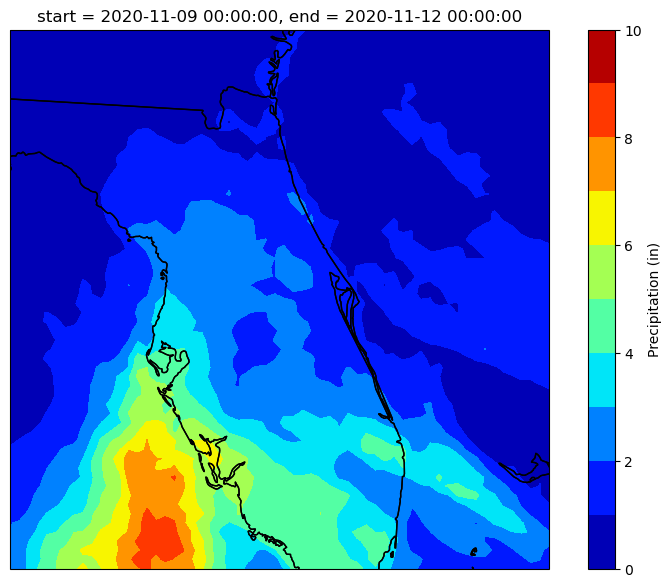

In [23]:
# Make the figure larger
fig = plt.figure(figsize=(10,7))

# Set the axes using the specified map projection
ax=plt.axes(projection=ccrs.PlateCarree())
clevs=[0.01,0.10,0.25,0.5,1,1.5,2,3,4,5,6,7,8,10,12,14,16,18,20,24,28,32,36,40]
imerg_plot = ax.contourf(sliced_lon_grid,sliced_lat_grid,total_precip/25.4,
            transform = ccrs.PlateCarree(),levels=np.arange(0,10.1,1),cmap='jet') # Convert units from mm to inches by dividing

# Add coastlines
# ax.coastlines()
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.COASTLINE)
plt.colorbar(imerg_plot,label='Precipitation (in)')
plt.title('start = ' + start_str + ', end = ' + end_str)


In [25]:
da = xr.DataArray(
    data=total_precip,
    dims=["lon", "lat"],
    coords=dict(
        lon=(["lon", "lat"], sliced_lon_grid),
        lat=(["lon", "lat"], sliced_lat_grid),
        time='start = ' + start_str + ', end = ' + end_str,
    ),
    attrs=dict(
        description="IMERG Precip Total",
        units="mm",
    ),
)

da.to_netcdf('/Users/acheung/data/intermediates/start = ' + start_str + ', end = ' + end_str + ' imerg.nc')

In [8]:
da

<xarray.DataArray (lon: 60, lat: 60)> Size: 14kB
array([[48.735004  , 59.280003  , 80.209984  , ..., 33.035004  ,
        49.530006  , 45.774998  ],
       [49.46999   , 60.875     , 79.51998   , ..., 59.609993  ,
        50.914993  , 43.76001   ],
       [54.43999   , 64.274994  , 79.229996  , ..., 60.229996  ,
        52.605007  , 48.109997  ],
       ...,
       [ 2.2450001 ,  0.145     ,  2.02      , ..., 14.8949995 ,
        17.480001  , 17.935003  ],
       [ 2.235     ,  0.5       ,  1.335     , ..., 17.204998  ,
        19.79      , 21.854996  ],
       [ 2.43      ,  1.11      ,  0.97499996, ..., 19.714996  ,
        22.639994  , 22.590004  ]], dtype=float32)
Coordinates:
    lon      (lon, lat) float32 14kB -84.35 -84.25 -84.15 ... -78.55 -78.45
    lat      (lon, lat) float32 14kB 25.55 25.55 25.55 ... 31.45 31.45 31.45
    time     <U54 216B 'start = 2020-11-09 00:00:00, end = 2020-11-12 00:00:00'
Attributes:
    description:  IMERG Precip Total
    units:        mm